## Iron Nanoparticles Experiments
November 16, 2023
Experiments by jmchan@lbl.gov, awojdyla@lbl.gov

This is the second first set of experiments on iron nanoparticles (provided my Jonathan Chan.)

The Pilatus deector is now about 1000 mm from the sample position

We do niot use bluesky -- just epics call through python.

partial log: go.lbl.gov/bl531/log2023

In [1]:
import epics
import numpy
from PIL import Image

In [56]:
#testing EPICS
epics.caput('13PIL1:cam1:Acquire',1)

1

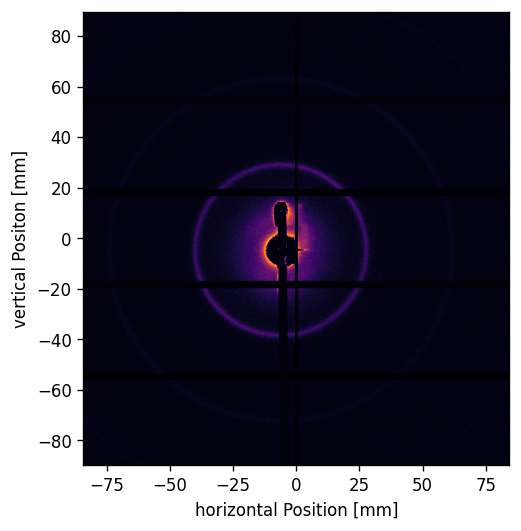

In [68]:
#read a image
import numpy as np
from PIL import Image

filepath = '/mnt/pilatus/sample_20231117_149.tif'

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))
# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
# extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels

mask = im_np > np.max(im_np)
im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [4]:
#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
#Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
#Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg
mono_deg(7000)

29.195768993164748

## Energy scan

In [13]:
from time import sleep as time_sleep

import numpy as np
#Es_eV = np.linspace(9000, 9100, 11)
plan = np.genfromtxt('/home/bl531/Downloads/ALSBL5311-XP-20231116a - Sheet2.csv', delimiter=',', skip_header=1)
Es_eV = plan[-13:,5]

for i_e in range(len(Es_eV)):
    mono_angle_deg = mono_deg(Es_eV[i_e])
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    print(mono_angle_deg)
    time_sleep(5)
    epics.caput('13PIL1:cam1:Acquire',1)

CA.Client.Exception...............................................
    Context: "Channel: "bl531_xps1:mono_angle_deg", Connecting to: 131.243.80.239:5064, Ignored: 192.168.10.123:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Fri Nov 17 2023 12:04:57.407996376
..................................................................


28.98170663915146
28.969980262609404
28.958271097060397
28.9465791040914
28.934904245405278
28.92324648282036
28.911605778269994
28.899982093802095
28.888375391578748
28.865212783082107
28.842117652343042
28.819089700723204
28.796128631369292


In [63]:
# Single energy scan
from time import sleep as time_sleep

Es_eV = 9000

mono_angle_deg = mono_deg(Es_eV)
epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
print(mono_angle_deg)
time_sleep(5)
epics.caput('13PIL1:cam1:Acquire',1)

25.479182679068188


1

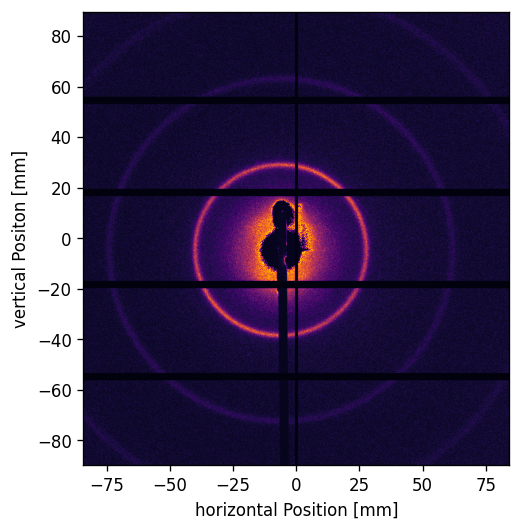

In [79]:
#read a image
import numpy as np
from PIL import Image

filepath = '/mnt/pilatus/sample_20231117_149.tif'

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))
# dealing with dyanmic range
#im_np[np.where(im_np>10.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
# extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels

mask = im_np > np.max(im_np)/50000
im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [80]:
from skimage.transform import warp, warp_polar

im_warp = warp_polar(im_np, center=[564,526])
plt.plot(np.sum(im_warp,axis=0))
plt.title('aximuthal sum of diffraction rings')
plt.xlabel('pixel radius')
plt.ylabel('image number')

#displaying the azimathal dewarping (for center of been adjustment)
plt.imshow(im_warp)
plt.show()


NameError: name 'warp_polar' is not defined

In [ ]:
# 120-149
# img_sum = ()
# for image in images:
#     #new_image = image_process_no_log(image)
#     new_image = image
#     im_warp = warp_polar(im_np, center=[526,564])
#     #plt.imshow(im_warp)
#     #plt.show()
#     img_sum += (im_warp,)

In [82]:
from skimage import io
#    #print(filepath)
#    img = io.imread(filepath)

#    images += (img,)

In [102]:
file_nb = 120+np.arange(30)
images = ()
for i_f in np.arange(len(file_nb)):
    folder = '/mnt/pilatus/'
    filename ='sample_20231117_%3.0f.tif' % file_nb[i_f]
    img = io.imread(folder+filename)
    images += (img,)


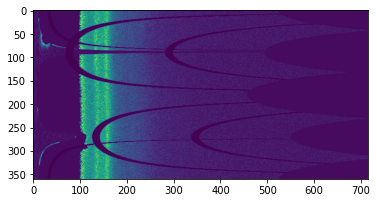

In [120]:
from skimage.transform import warp, warp_polar

#im_warp = warp_polar(images[-5], center=[564,526])
im_warp = warp_polar(images[-5], center=[549,456])



#displaying the azimathal dewarping (for center of been adjustment)
plt.imshow(im_warp)
plt.show()


Text(0, 0.5, 'image number')

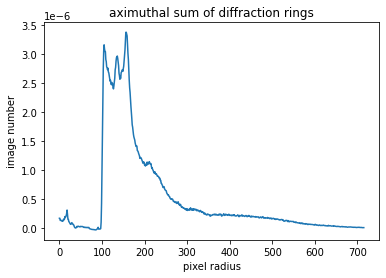

In [121]:
plt.plot(np.sum(im_warp,axis=0))
plt.title('aximuthal sum of diffraction rings')
plt.xlabel('pixel radius')
plt.ylabel('image number')

In [122]:
from skimage.transform import warp, warp_polar
img_sum = ()
for image in images:
    #new_image = image_process_no_log(image)
    new_image = image
    im_warp = warp_polar(new_image, center=[549,456])
    #plt.imshow(im_warp)
    #plt.show()
    img_sum += (im_warp,)

/tmp/ipykernel_603626/1861420229.py:2: RuntimeWarning: invalid value encountered in power
  plt.imshow(np.sum(img_sum,axis=1)**0.1, aspect=5)


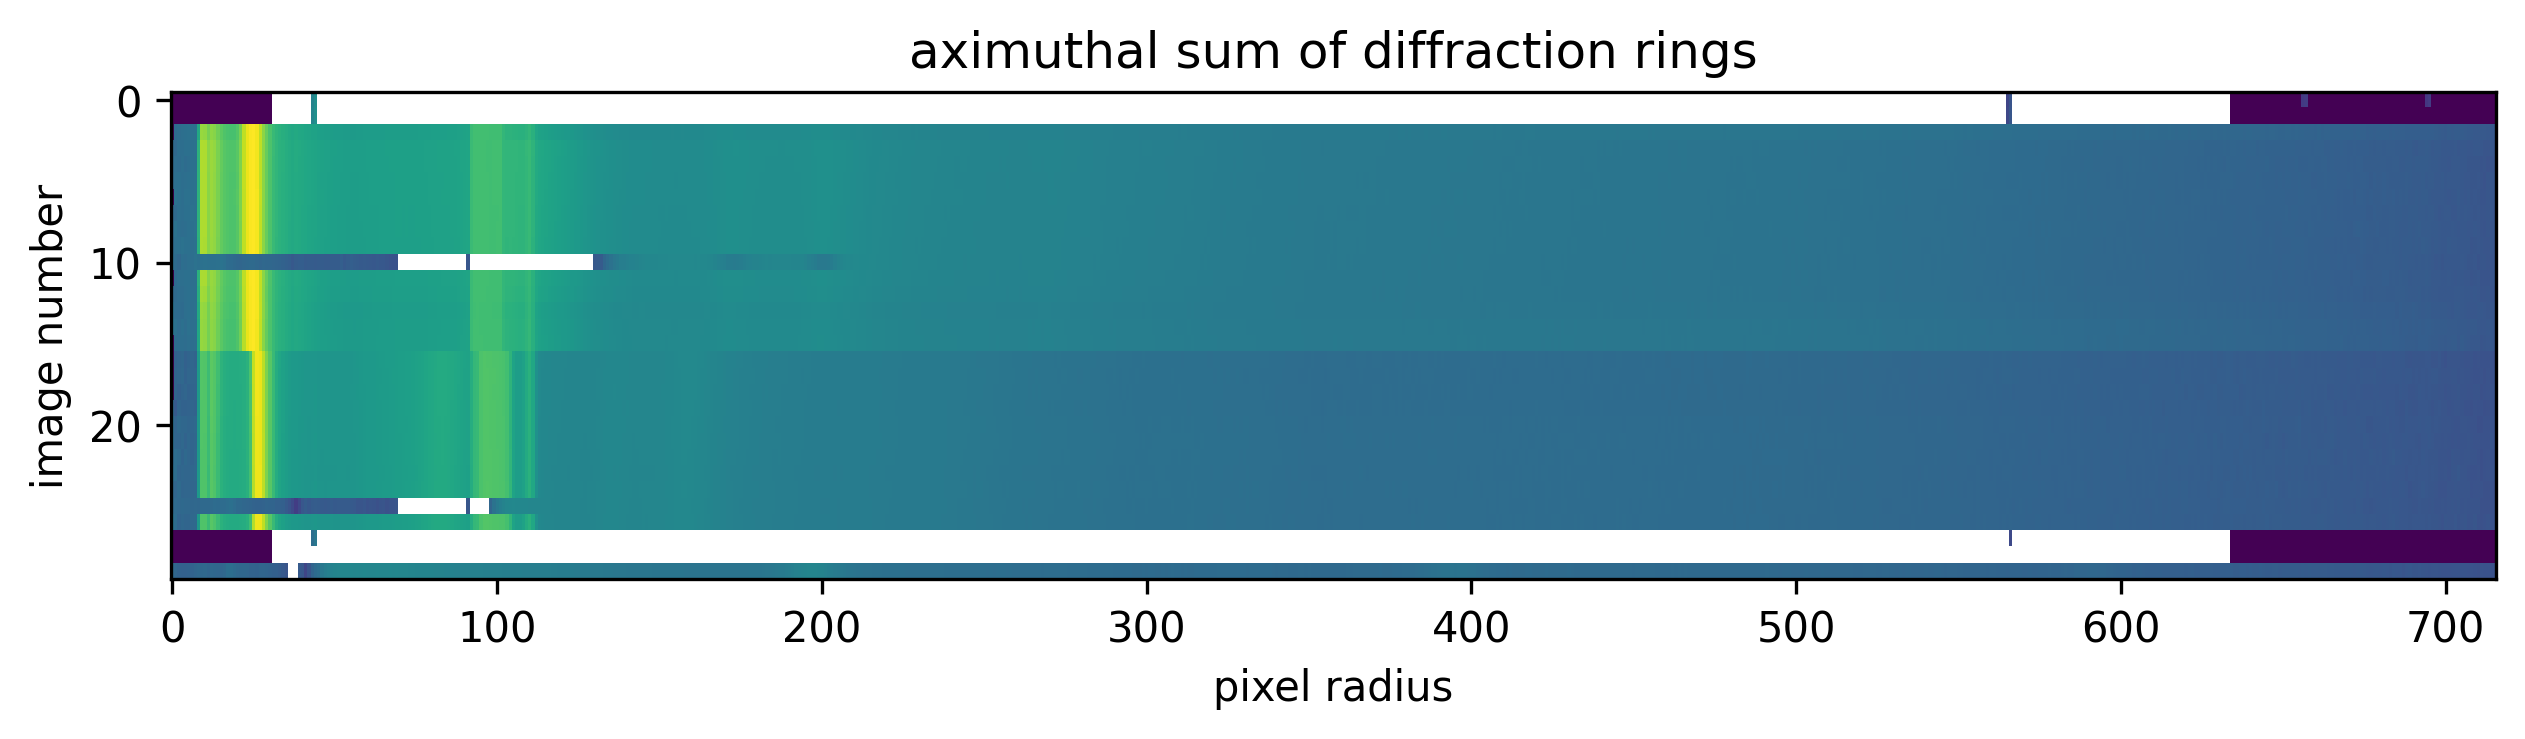

In [125]:
fig=plt.figure(figsize=(10, 10), dpi= 300, facecolor='w', edgecolor='k')
plt.imshow(np.sum(img_sum,axis=1)**0.1, aspect=5)
plt.title('aximuthal sum of diffraction rings')
plt.xlabel('pixel radius')
plt.ylabel('image number')
#plt.imshow(np.sum(np.sum(img_sum,axis=1),axis=0))

plt.show()

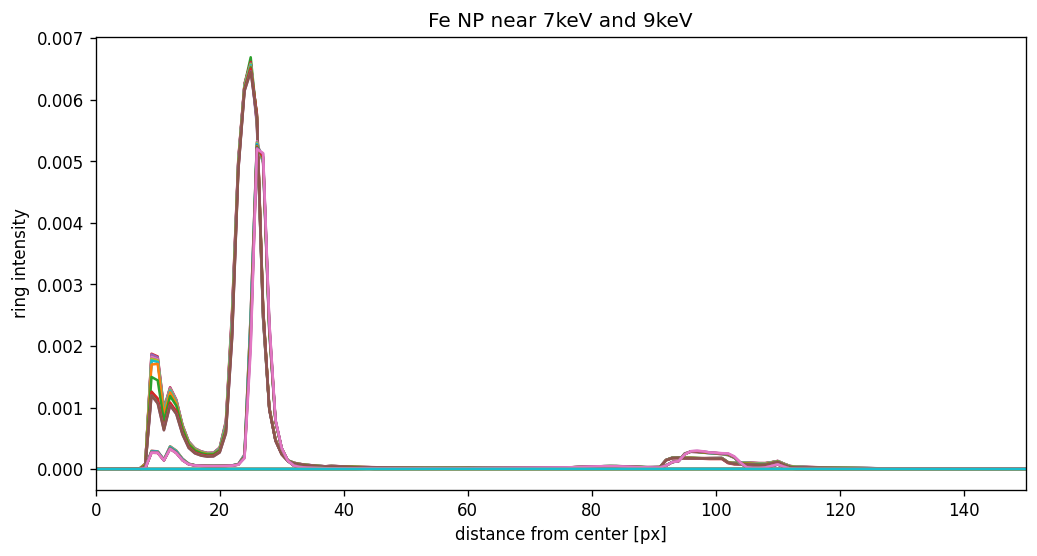

In [135]:
fig=plt.figure(figsize=(10, 5), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(np.transpose(np.sum(img_sum,axis=1)))
plt.xlim([0,150])
plt.xlabel('distance from center [px]')
plt.ylabel('ring intensity')
plt.title('Fe NP near 7keV and 9keV')
plt.show()